# Step #1 Load the Data

In [2]:
# Time Series Forecasting - Feature Engineering For Multivariate Models (Stock Market Prediction Example)
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions  
import numpy as np # Fundamental package for scientific computing with Python 
import pandas as pd # Additional functions for analysing and manipulating data 
from datetime import date # Date Functions 
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates 
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data 
import matplotlib.dates as mdates # Formatting dates 
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors 
import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks 
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers 
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training 
from sklearn.preprocessing import RobustScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data  
#from keras.optimizers import Adam # For detailed configuration of the optimizer 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})


# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Quick overview of dataset
df.head()

Tensorflow Version: 2.5.0
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,2292.919922,2293.590088,2269.110107,2269.149902,2269.149902,1237820000
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000


# Step #2 Explore the Data

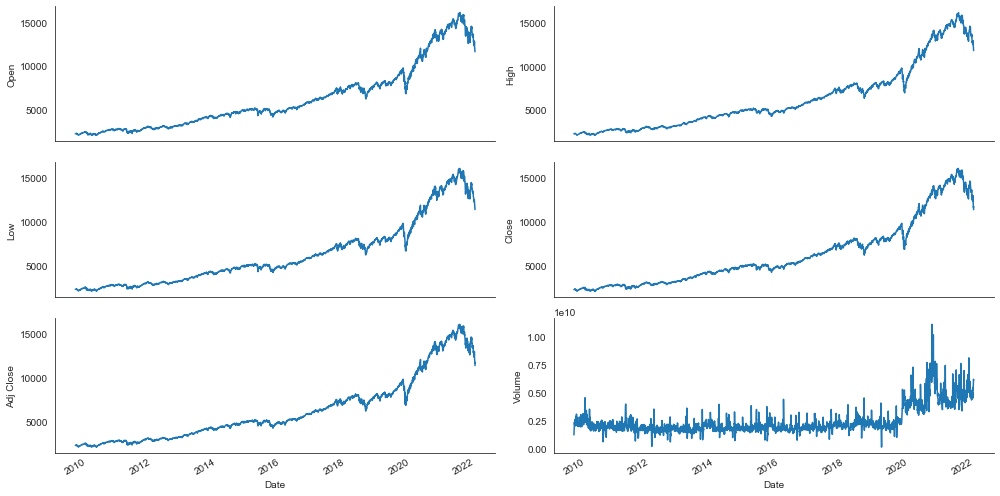

In [3]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Feature Engineering

In [4]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d") 
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 
train_df

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
Date,,,,,,,,,
2009-12-31,2292.919922,2293.590088,2269.110107,2269.149902,2269.149902,1237820000,31,12,2009
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,04,01,2010
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,05,01,2010
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,06,01,2010
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,07,01,2010
...,...,...,...,...,...,...,...,...,...
2022-05-05,12787.519531,12787.519531,12183.559570,12317.690430,12317.690430,5269260000,05,05,2022
2022-05-06,12246.830078,12358.419922,11990.150391,12144.660156,12144.660156,5311020000,06,05,2022
2022-05-09,11923.030273,11990.610352,11574.940430,11623.250000,11623.250000,5911380000,09,05,2022


In [5]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    return df

                   Close  Bollinger_Upper  Bollinger_Lower
Date                                                      
2022-05-05  12317.690430     14060.371891     12077.483188
2022-05-06  12144.660156     13974.276325     11988.314788
2022-05-09  11623.250000     13979.768976     11774.047137
2022-05-10  11737.669922     13976.307743     11610.079366
2022-05-11  11364.240234     14003.092218     11382.561884


<function matplotlib.pyplot.show(close=None, block=None)>

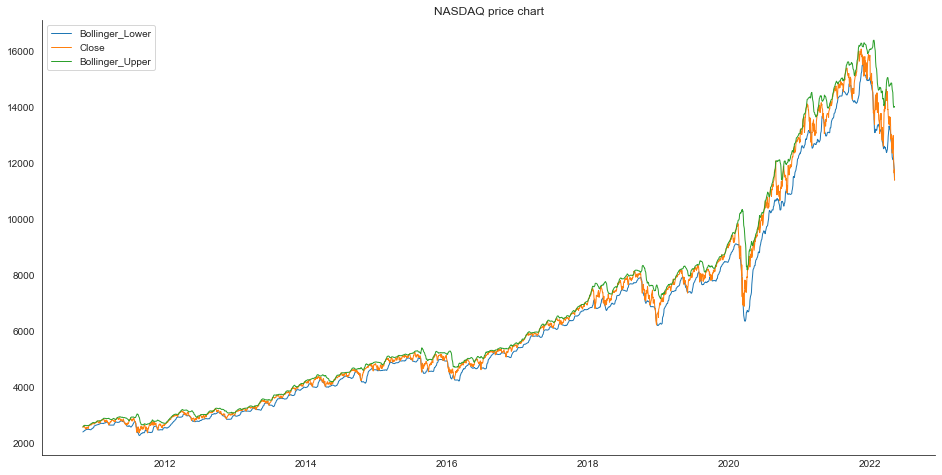

In [6]:
# List of considered Features
FEATURES = [
#             'High',
#             'Low',
#             'Open',
              'Close',
#             'Volume',
#             'Day',
#             'Month',
#             'Year',
#             'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
#             'MACD',
#             'RSI',
#             'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
#             'MA100',            
#             'MA50',
#             'MA26',
#             'MA14_low',
#             'MA14_high',
#             'MA12',
#             'EMA20',
#             'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE'
           ]

# Create the dataset with features
df_features = createFeatures(train_df)

# Shift the timeframe by 10 month
use_start_date = pd.to_datetime("2010-11-01" )
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
data_filtered_ext = df_features[FEATURES].copy()

# We add a prediction column and set dummy values to prepare the data for scaling
#data_filtered_ext['Prediction'] = data_filtered_ext['Close'] 
print(data_filtered_ext.tail().to_string())

# remove Date column before training
dfs = data_filtered_ext.copy()
#del dfs[('Prediction')]
register_matplotlib_converters()

# Define plot parameters 
fig, ax = plt.subplots(figsize=(16, 8))
assetname_list = []
# Plot each column
for i in range(dfs.shape[1]):
    assetname = dfs.columns[i-1]
    ax.plot(data_filtered_ext.index, data_filtered_ext[assetname], label=assetname, linewidth=1.0)
    assetname_list.append(assetname)

# Configure and show the plot    
ax.set_title(stockname + ' price chart')
ax.legend()
ax.tick_params(axis="x", labelsize=10, length=0)   
plt.show

# Step #4 Scaling and Transforming the Data

In [7]:
# Calculate the number of rows in the data
nrows = dfs.shape[0]
np_data_unscaled = np.reshape(np.array(dfs), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2901, 3)


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][0])
print(y_train[0])

(2271, 50, 1) (2271,)
(580, 50, 1) (580,)
-0.5794152691439222
-0.5794152691439222


# Step #5 Model Training

In [9]:
# Configure the neural network model
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 32; patience = 8; 

# uncomment to customize the learning rate
learn_rate = "standard" # 0.05
# adam = Adam(learn_rate=learn_rate) 

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,
                  validation_data=(x_test, y_test))

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

timesteps: 50, features:1
Parameters: ['epochs 100', 'batch_size 32', 'patience 8', 'optimizer adam with learn rate standard', 'loss mean_squared_error']
Epoch 1/100
71/71 [==============================] - 8s 52ms/step - loss: 0.0996 - val_loss: 0.4199
Epoch 2/100
71/71 [==============================] - 3s 38ms/step - loss: 0.0918 - val_loss: 0.2412
Epoch 3/100
71/71 [==============================] - 3s 38ms/step - loss: 0.0916 - val_loss: 0.1332
Epoch 4/100
71/71 [==============================] - 3s 38ms/step - loss: 0.0916 - val_loss: 0.0936
Epoch 5/100
71/71 [==============================] - 3s 38ms/step - loss: 0.0916 - val_loss: 0.0664
Epoch 6/100
71/71 [==============================] - 3s 39ms/step - loss: 0.0916 - val_loss: 0.0645
Epoch 7/100
21/71 [=======>......................] - ETA: 1s - loss: 0.0952

# Step #6 Evaluate Model Performance

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(dfs['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(dfs['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)
sns.set_palette(["#090364", "#5E14CD", "#36D3DE"])

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
plt.legend()
plt.show()

NameError: name 'model' is not defined